In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
DATA_ROOT = "../data/"

## Shannon Entropy calculation

In [3]:
from math import log

def calShannonEntr(dataSet):
    # the last colums is label
    numEntries = len(dataSet)
    labelCounts = {}
    for instance in dataSet:
        label = instance[-1]
        if label not in labelCounts.keys():
            labelCounts[label] = 0
        labelCounts[label] += 1
    
    entropy = 0.0
    for key, value in labelCounts.items():
        prob = float(value) / numEntries
        entropy += -prob*log(prob, 2)
    
    return entropy

In [4]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
labels = ['no surfacing', 'flippers']
calShannonEntr(dataSet)

0.9709505944546686

In [5]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no'],
           [1, 1, 'maybe']]
labels = ['no surfacing', 'flippers']
calShannonEntr(dataSet) # the larger entropy indicate the messier dataset

1.4591479170272448

## split data set

In [6]:
def splitDataSet(dataSet, axis, value):
    resDataSet = []
    for instance in dataSet:
        if instance[axis] == value:
            reduceInstance = instance[:axis] # 0 ~ axis-1
            reduceInstance.extend(instance[ (axis+1)::]) # axis+1 ~ end
            resDataSet.append(reduceInstance)
    return resDataSet
## extend vs append : http://stackoverflow.com/questions/252703/append-vs-extend

In [7]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
splitDataSet(dataSet, 0, 1)

[[1, 'yes'], [1, 'yes'], [0, 'no']]

## select best feature to split

In [8]:
def selectBestFeatureToSplit(dataSet):
    # the last column is label
    numFeatures = len(dataSet[0]) - 1 
    baseEntropy = calShannonEntr(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featValList = [instance[i] for instance in dataSet]
        uniqueVals = set(featValList)
        curEntropy = 0.0
        for value in uniqueVals:
            subSet = splitDataSet(dataSet, i, value)
            prob = float(len(subSet)) / float(len(dataSet))
            curEntropy += prob * calShannonEntr(subSet)
            
        curInfoGain = baseEntropy - curEntropy
        if curInfoGain > bestInfoGain:
            bestInfoGain = curInfoGain
            bestFeature = i
    return bestFeature

In [9]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
selectBestFeatureToSplit(dataSet)

0

## construct decision tree ( ID3)

In [10]:
import operator
def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1

    sortedClassCount = sorted(classCount.iteritems(), 
                             key = operator.itemgetter(1),
                             reverse = True)
    return sortedClassCount[0][0]

def createTree(dataSet, labels):
    classList = [instance[-1] for instance in dataSet]
    
    # termination
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    # grow tree
    bestFeature = selectBestFeatureToSplit(dataSet)
    bestFeatureLabel = labels[bestFeature]
    myTree = {bestFeatureLabel:{}}
    del labels[bestFeature]
    bestFeatureValues = [instance[bestFeature] for instance in dataSet]
    uniqueValue = set(bestFeatureValues)
    for value in uniqueValue:
        subLabels = labels[:]
        subDataSet = splitDataSet(dataSet, bestFeature, value)
        myTree[bestFeatureLabel][value] = createTree(subDataSet, subLabels)
    return myTree

In [11]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
labels = ['no surfacing', 'flippers']
createTree(dataSet, labels)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## plot tree by annotations in matplotlib

### matplotlib annotation

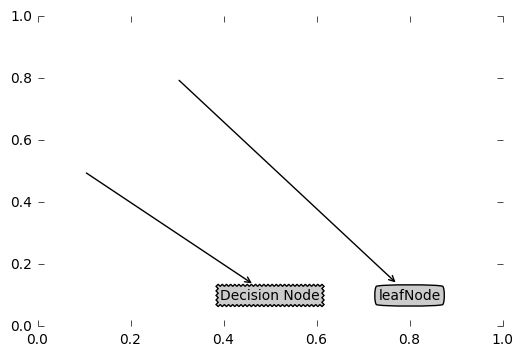

In [12]:
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")

def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    createPlot.ax1.annotate(nodeTxt, 
                            xy=parentPt, xycoords='axes fraction', 
                            xytext = centerPt, textcoords = 'axes fraction', 
                            va = "center", ha = "center", bbox = nodeType, arrowprops = arrow_args)

def createPlot():
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    createPlot.ax1 = plt.subplot(111, frameon = False)
    plotNode("Decision Node", (0.5, 0.1), (0.1, 0.5), decisionNode)
    plotNode("leafNode", (0.8, 0.1), (0.3, 0.8), leafNode)

createPlot()

### annotation tree

In [13]:
def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs

def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = myTree.keys()[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            curDepth = 1 + getTreeDepth(secondDict[key])
        else:
            curDepth = 1
        
        if(curDepth > maxDepth):
            maxDepth = curDepth
    return maxDepth

def retrieveTree(i):
    listOfTrees = [{'no surfacing' : {0: 'no', 1: {'flippers' : {0 : 'no', 1 : 'yes'}}}},
                  {'no surfacing': {0: 'no', 1:{'flippers' : {0: {'head': {0: 'no', 1:'yes'}}, 1:'no'}}}}]
    return listOfTrees[i]


In [14]:
print(retrieveTree(1))
print(retrieveTree(0))
print(getNumLeafs(retrieveTree(1)))
print(getNumLeafs(retrieveTree(0)))
print(getTreeDepth(retrieveTree(1)))
print(getTreeDepth(retrieveTree(0)))

{'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
4
3
3
2


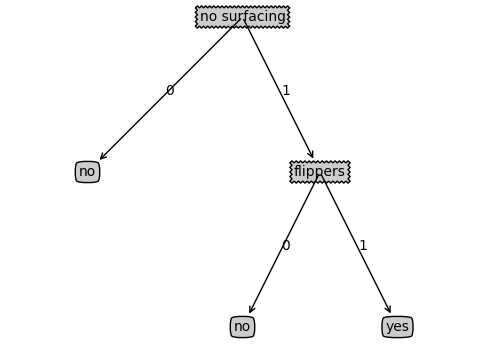

In [15]:
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotTree(myTree, parentPt, nodeTxt):#if the first key tells you what feat was split on
    numLeafs = getNumLeafs(myTree)  #this determines the x width of this tree
    depth = getTreeDepth(myTree)
    firstStr = myTree.keys()[0]     #the text label for this node should be this
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW, plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__=='dict':#test to see if the nodes are dictonaires, if not they are leaf nodes   
            plotTree(secondDict[key],cntrPt,str(key))        #recursion
        else:   #it's a leaf node print the leaf node
            plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD
#if you do get a dictonary you know it's a tree, and the first element will be another dict

def TreeCreatePlot(inTree):
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)    #no ticks
    #createPlot.ax1 = plt.subplot(111, frameon=False) #ticks for demo puropses 
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()
    
TreeCreatePlot(retrieveTree(0))

## test and save classifier

### test algorithm

In [16]:
def classify(decisionTree, featLabels, testVec):
    firstStr = decisionTree.keys()[0]
    secondDict = decisionTree[firstStr]
    featIndex = featLabels.index(firstStr)
    for key in secondDict.keys():
        if testVec[featIndex] == key:
            if type(secondDict[key]).__name__ == 'dict':
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                classLabel = secondDict[key]
    return classLabel

In [17]:
dataSet = [[1, 1, 'yes'],
           [1, 1, 'yes'],
           [1, 0, 'no'],
           [0, 1, 'no'],
           [0, 1, 'no']]
labels = ['no surfacing', 'flippers']
myTree = retrieveTree(0)
print(myTree)
classify(myTree, labels, [1, 1])

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


'yes'

### save tree

In [18]:
def storeTree(decisionTree, filename):
    import pickle
    fw = open(filename, 'w')
    pickle.dump(decisionTree, fw)
    fw.close()

def grabTree(filename):
    import pickle
    fr = open(filename, 'r')
    return pickle.load(fr)

In [19]:
storeTree(retrieveTree(0), 'decisionTreeClassifier.txt')
grabTree('decisionTreeClassifier.txt')

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}

## A real case

In [20]:
fr = open(DATA_ROOT+"lensesDataSet/lenses.txt")
lenses = [instance.strip().split('\t') for instance in fr.readlines()]
lensesLabels = ['age', 'prescript', 'astigmatic', 'tearRate']
lensesTree = createTree(lenses, lensesLabels)
lensesTree

{'tearRate': {'normal': {'astigmatic': {'no': {'age': {'pre': 'soft',
      'presbyopic': {'prescript': {'hyper': 'soft', 'myope': 'no lenses'}},
      'young': 'soft'}},
    'yes': {'prescript': {'hyper': {'age': {'pre': 'no lenses',
        'presbyopic': 'no lenses',
        'young': 'hard'}},
      'myope': 'hard'}}}},
  'reduced': 'no lenses'}}

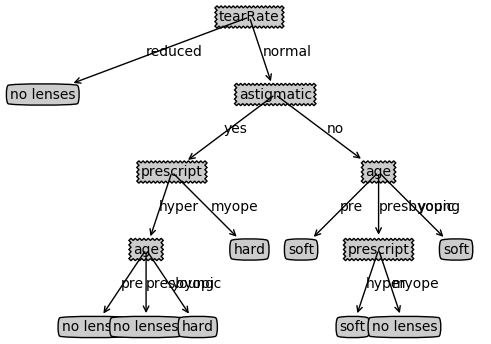

In [21]:
TreeCreatePlot(lensesTree)